# Using LSTM to predict next up and down
## v2: Predict up and downs of the average of $\mathbf{nforward}=10$ following prices

1. Too slow to predict (next trade may happen in millisecond)
2. Only classification of up, down and same. No quantitative prediction (can be improved to predict quantity of price movement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle

Using TensorFlow backend.


In [2]:
hidden_dim = 30
n_epochs = 100
time_steps = 50
batch_size = 128
activation = "tanh"
loss = 'categorical_crossentropy'
stop_patience=20

dpi=200

In [3]:
def reshape_dataset(x, y):
    if x is not None:
        if len(x.shape) == 2:
            x = x.reshape(x.shape[0], x.shape[1], 1)
    if len(y.shape) == 1:
        y = y.reshape(y.shape[0],1)
    return x, y 

class LSTM_Model():
    def __init__(self):
        self.model = Sequential()
        return 
    
    def build(self,  time_steps = time_steps, data_dim = 1, output_dim = 3):
        # expected input batch shape: (batch_size, timesteps, data_dim)
        # the sample of index i in batch k is the follow-up for the sample i in batch k-1.
        self.model.add(LSTM(hidden_dim, activation=activation, return_sequences=True, input_shape=(time_steps, data_dim)))
        self.model.add(LSTM(hidden_dim, activation=activation, return_sequences=True))
        self.model.add(LSTM(hidden_dim, activation=activation))
        self.model.add(Dense(output_dim, activation = 'softmax'))
        
        opt=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        self.model.compile(loss = loss, optimizer=opt, metrics=['accuracy']) 
        return self.model

    def train_test(self, x, y, plot = False):
        
        size = len(x)
        if size!=len(y):
            return None
        x = x[: batch_size * (size // batch_size)]
        y = y[: batch_size * (size // batch_size)]
        
        x, y = reshape_dataset(x, y)

        x_train, x_validation, y_train, y_validation= train_test_split(x, y, test_size = 0.1, shuffle = False)
        print('train', x_train.shape, y_train.shape)
        print('validation', x_validation.shape, y_validation.shape)
       
        early_stopping = EarlyStopping(monitor='val_loss', patience=stop_patience, mode="min", verbose=2, restore_best_weights=True)
        history = self.model.fit(x_train, y_train, batch_size = batch_size, epochs = n_epochs,
                                 validation_data=(x_validation, y_validation),callbacks=[early_stopping])
        
        self.y_pred = self.predict(x_validation)
        self.y_validation_true = y_validation
        
        if plot == True:
            self.train_plot = self.view_accuracy(self.predict(x_train).argmax(axis=1), y_train.argmax(axis=1), 'Train')
            self.validation_plot = self.view_accuracy(self.predict(x_validation).argmax(axis=1), y_validation.argmax(axis=1), 'Validation')
        return history

    def predict(self, x_validation):
        pred = self.model.predict(x_validation)
        return pred
    
    def view_accuracy(self, y_pred = None, y_true = None, plot_name = 'Test', num=100):
        if y_pred is None:
            y_pred = self.y_pred.argmax(axis=1)
            y_true = self.y_validation_true.argmax(axis=1)
        
        plt.style.use('seaborn')
        plt.figure(figsize = (20,6), dpi=dpi)
        plt.grid(True)
        plt.plot(y_pred[:num], color = 'lightcoral')
        plt.plot(y_true[:num], color = 'cornflowerblue', linewidth = 1)
        plt.title('{}_{}'.format(ticker, plot_name))
        plt.legend(['predict', 'true'])
#         if plot_name == 'Test':
#             plt.savefig('{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size)))
#         else:
#             plt.savefig('{}_{}_{}_{}.png'.format(ticker, plot_name, str(time_steps), str(batch_size)))


In [4]:
import os

data_dir="./data/"
ticker="TSLA"

date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]

nforward=10

def load_data(ticker, date):
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
    
    # Feature Engineering
    df["direction"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(np.sign)
    df["pct_change"]=df["trade_px"].pct_change()
    
    mysign=lambda x: 0 if abs(x)<1e-5 else (1 if x>0 else -1)
    df["label"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
    # df["label"]=(df["trade_px"].shift(-1)-df["trade_px"]).apply(np.sign) # last version
    
    df.fillna(method="ffill",inplace=True)
    df.dropna(axis=0,inplace=True)
    # print(df.head(10),df.shape)
    # print("NaN number: ",df.isna().sum().sum())
    
    return df[["trade_px","trade_size","pct_change","direction","label"]].values

def create_dataset(ticker=ticker, dates=train_date_list, time_steps = time_steps, input_scaler=None):  

    for i,d in enumerate(dates):
        datanew = load_data(ticker,d)
        if i==0:
            data=datanew
        else:
            data=np.vstack((data, datanew))
            
    label=data[:,-1]
    data=data[:,:-1]
    
    if input_scaler is None:
        scaler=StandardScaler()
        data=scaler.fit_transform(data)
    else:
        data=input_scaler.transform(data)
        scaler=input_scaler

    x = [data[0 : time_steps]]
    y = [label[time_steps-1]]
    N=len(data)//time_steps
    
    print(N)
    for i in range(1, N):
        t = data[i*time_steps: (i + 1)*time_steps]
        x = np.vstack((x, [t]))
        y.append(label[(i + 1)*time_steps-1])

    y=pd.get_dummies(y)
    #print(y)
   
    return x,y.values,scaler

# x,y,_=create_dataset()
# y.mean(axis=0)

In [11]:
def loss_plot(history, plot_name = 'Loss'): # type(history) is dict
    loss = np.asarray(history['loss'])
    val_loss = np.asarray(history['val_loss'])
    
    plt.style.use('seaborn')
    plt.figure(figsize = (20,6), dpi=dpi)
    plt.grid(True)
    plt.plot(loss, color = 'darkgrey')
    plt.plot(val_loss, color = 'tan')
    plt.legend(['loss', 'val_loss'])
    # plt.savefig('{}_{}_{}_{}_{}.png'.format(ticker, plot_name, str(n_epochs), str(time_steps), str(batch_size)))

def new_data_test(ticker, plot = True):
    # Load train data
    x, y, scaler = create_dataset(ticker)
    print("Finished loading data.")
    
    with open("model/LSTMv2_scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
        pickle.dump(scaler,f)
    
    # Build model, in-sample train test
    l = LSTM_Model()
    l.build(time_steps = time_steps, data_dim = x.shape[-1], output_dim = y.shape[-1])
    train_history = l.train_test(x, y, plot)  
    if plot == True:
        loss_plot(train_history.history)
    
    with open("model/LSTMv2_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"wb") as f:
        pickle.dump(l,f)
        
    # Out-of-sample test
    for test_date in test_date_list:
        # create test dateset
        x_test, y_test, _ = create_dataset(ticker=ticker, dates=[test_date], time_steps = time_steps, input_scaler=scaler)
        x_test, y_test = reshape_dataset(x_test, y_test)
    
        # use precious trained model to test
        y_test_pred = l.predict(x_test)
        if plot == True:
            l.view_accuracy(y_test_pred.argmax(axis=1), y_test.argmax(axis=1))
        print(test_date+" accuracy: ",np.mean(y_test_pred.argmax(axis=1)==y_test.argmax(axis=1)))
    return l.model


15154
Finished loading data.
train (13593, 50, 4) (13593, 3)
validation (1511, 50, 4) (1511, 3)
Train on 13593 samples, validate on 1511 samples
Epoch 1/100
13593/13593 [==============================] - 10s 766us/step - loss: 0.8649 - accuracy: 0.4702 - val_loss: 0.8404 - val_accuracy: 0.4825
Epoch 2/100
13593/13593 [==============================] - 9s 695us/step - loss: 0.8301 - accuracy: 0.4889 - val_loss: 0.8374 - val_accuracy: 0.5116
Epoch 3/100
13593/13593 [==============================] - 9s 688us/step - loss: 0.8121 - accuracy: 0.5103 - val_loss: 0.8115 - val_accuracy: 0.5553
Epoch 4/100
13593/13593 [==============================] - 10s 700us/step - loss: 0.7844 - accuracy: 0.5457 - val_loss: 0.7903 - val_accuracy: 0.5731
Epoch 5/100
13593/13593 [==============================] - 10s 701us/step - loss: 0.7617 - accuracy: 0.5777 - val_loss: 0.7746 - val_accuracy: 0.5645
Epoch 6/100
13593/13593 [==============================] - 10s 704us/step - loss: 0.7534 - accuracy: 0.5837

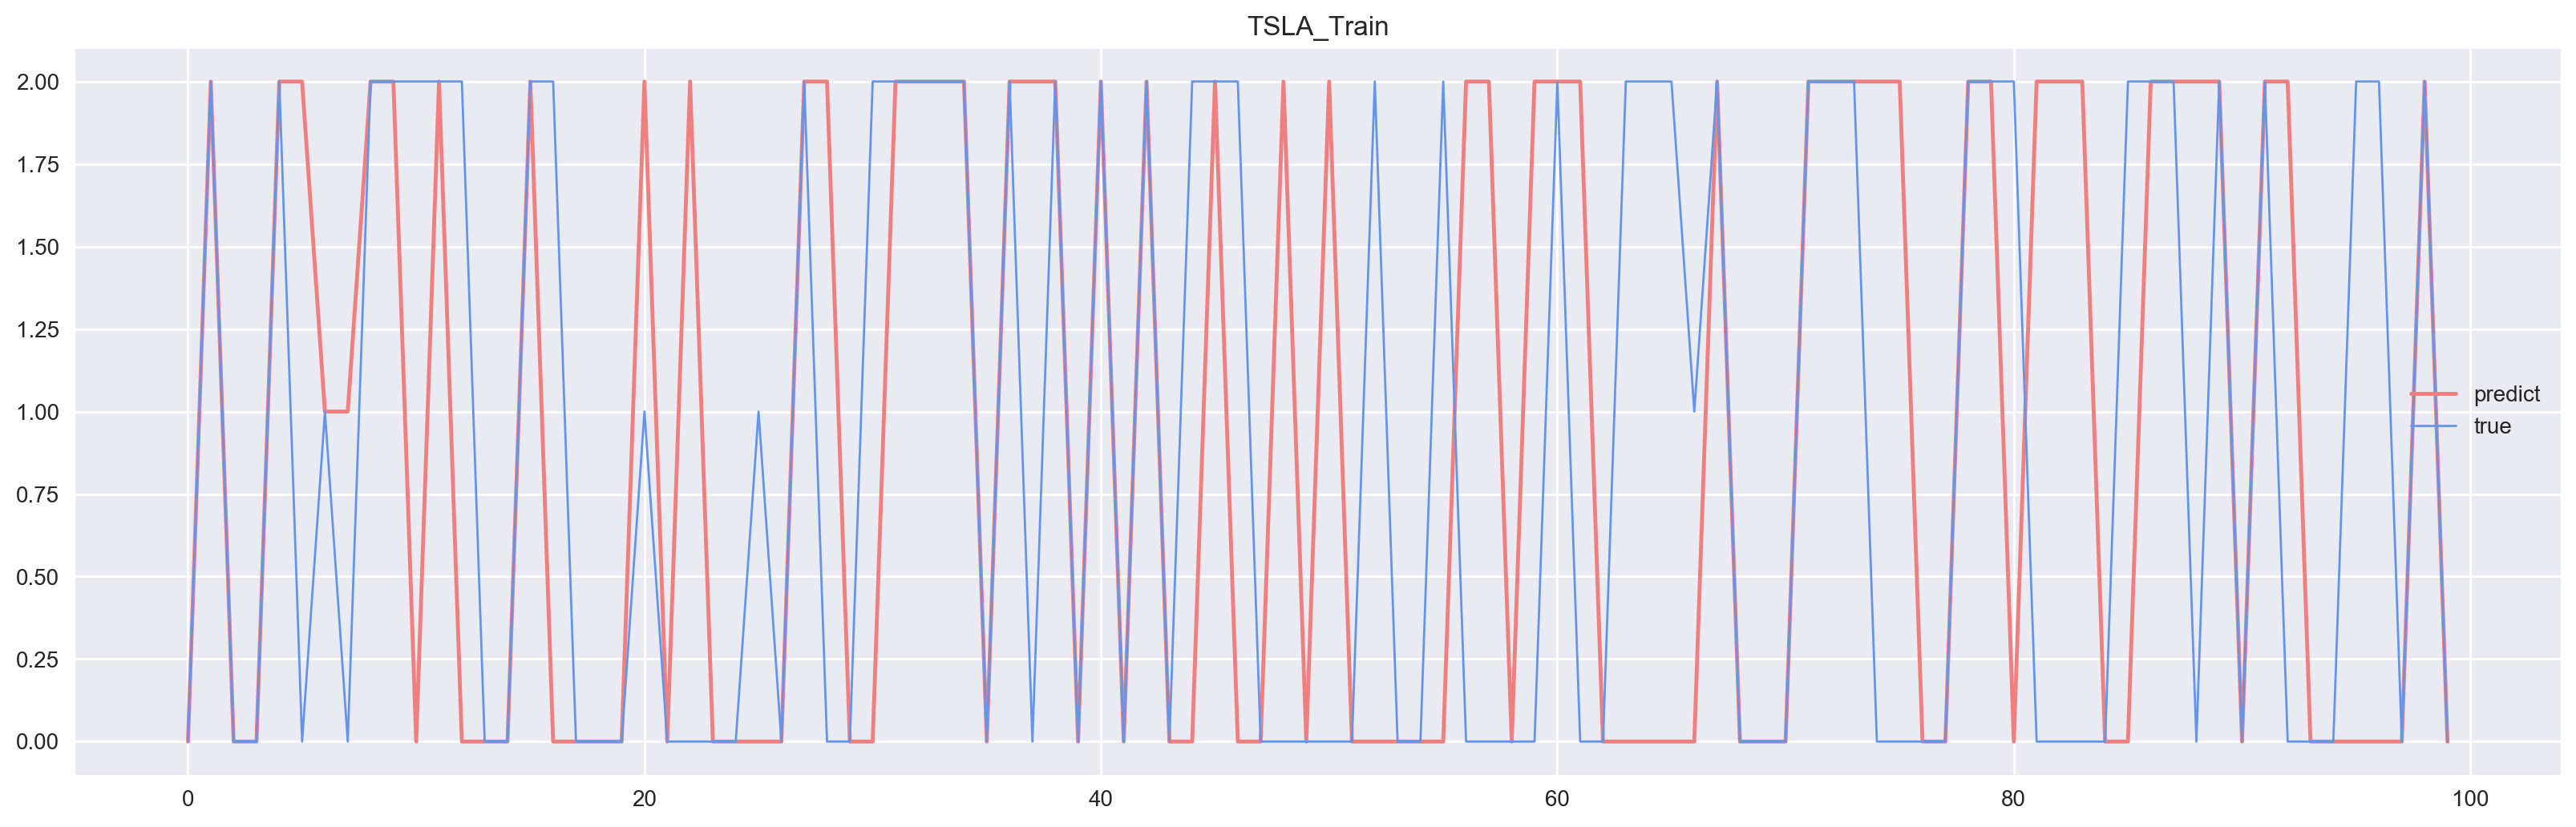

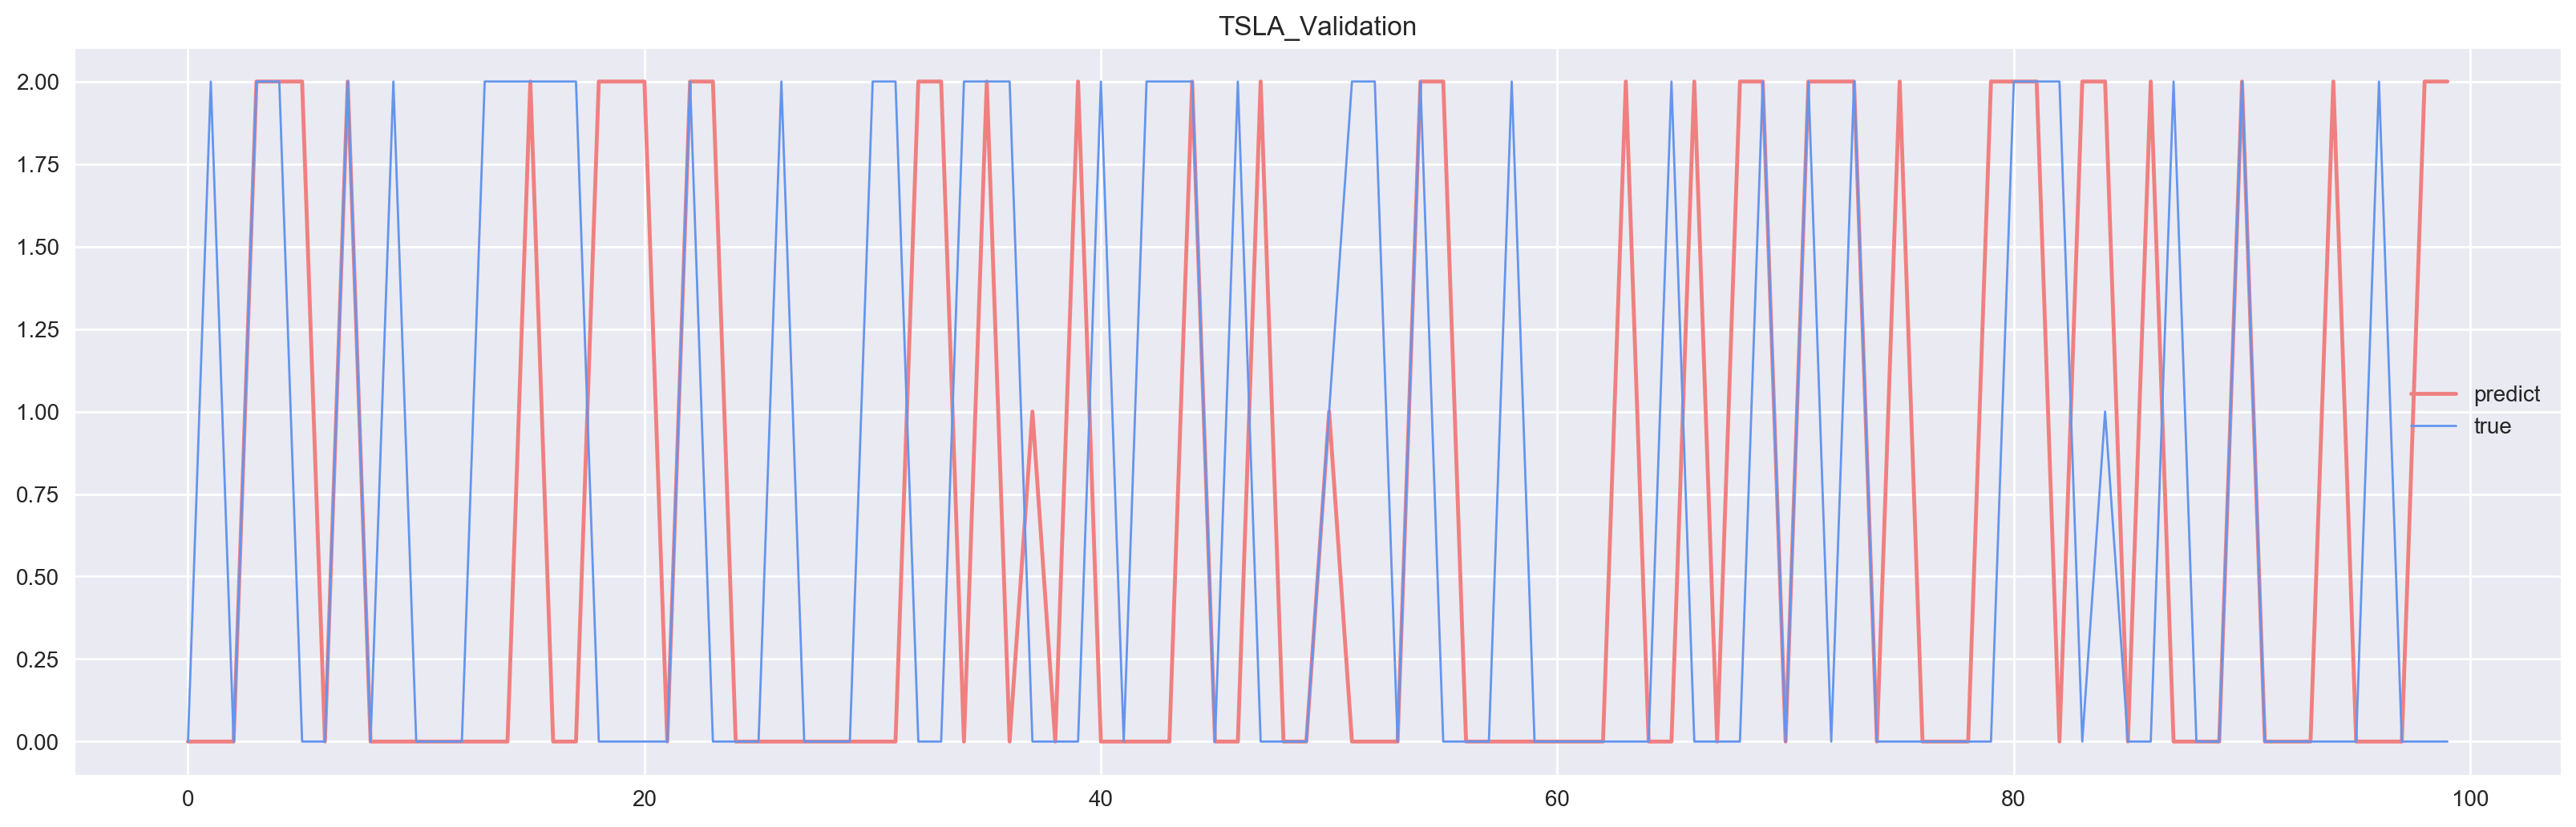

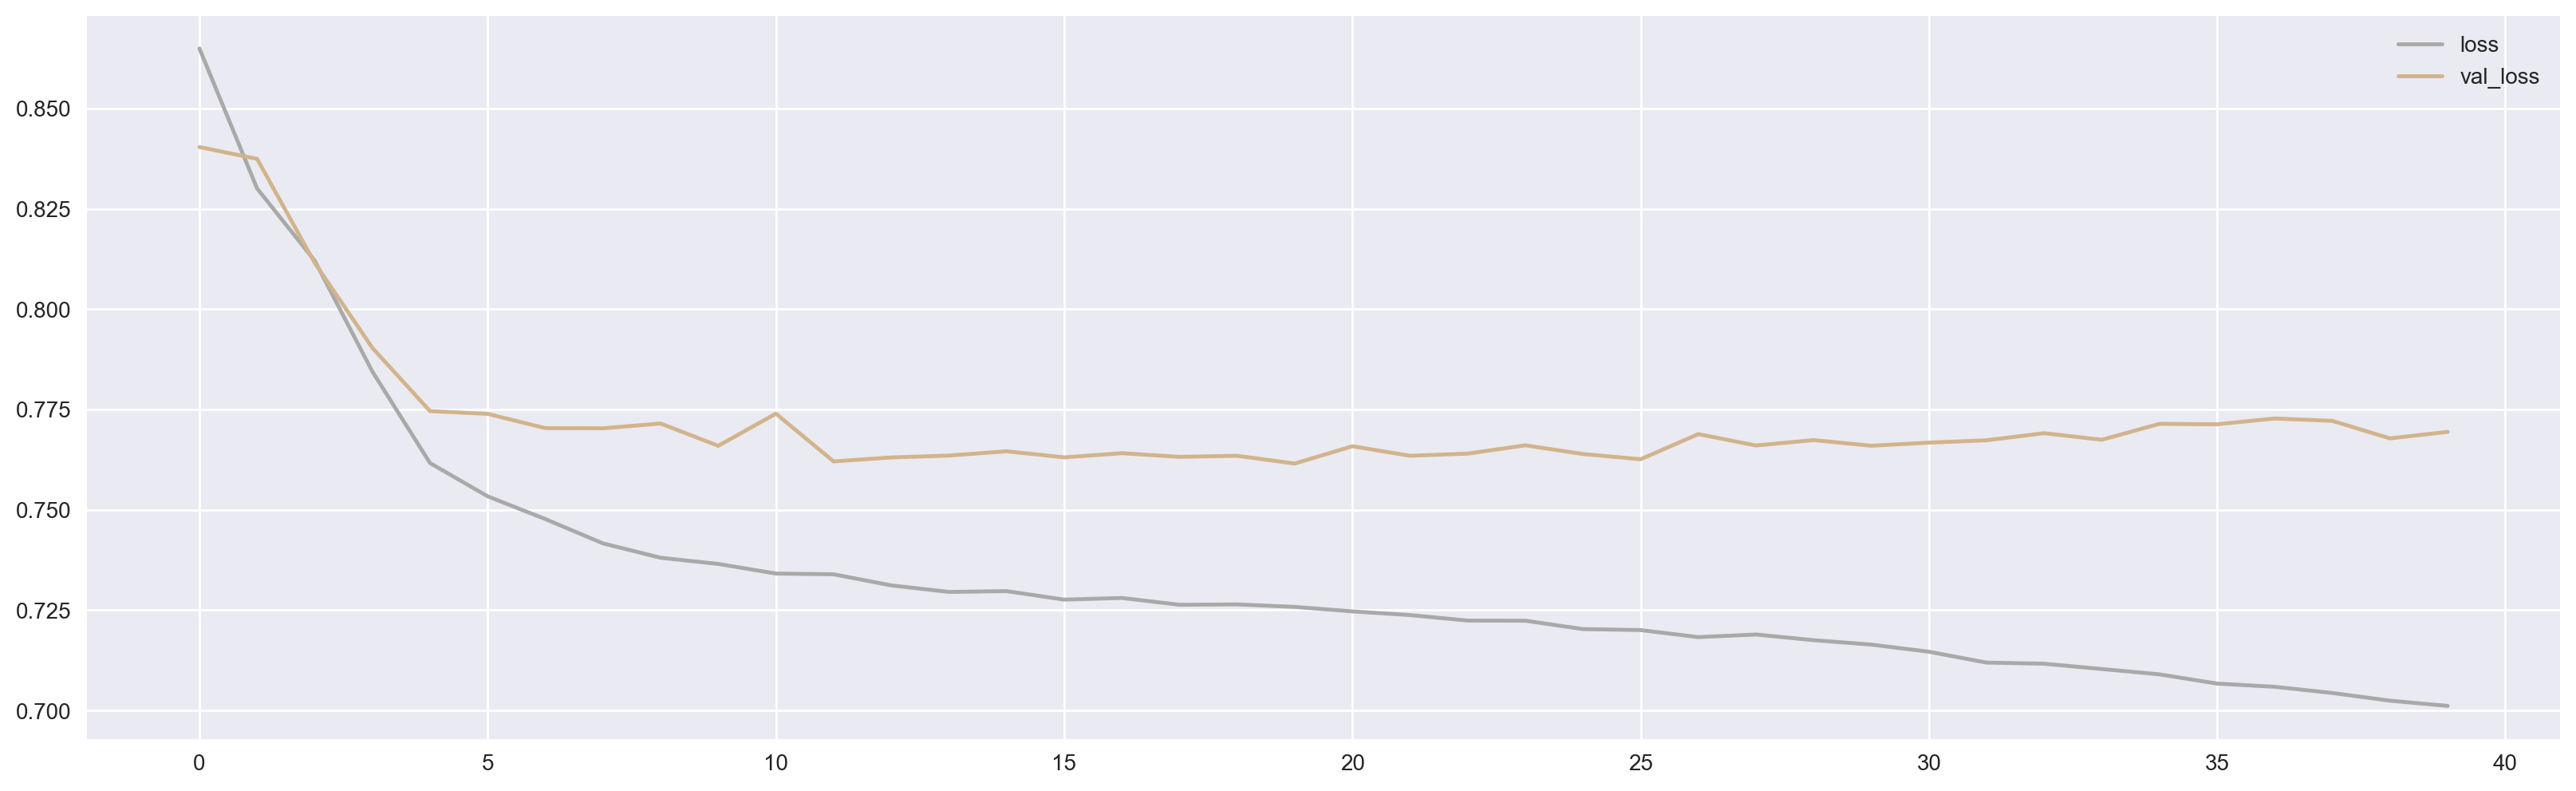

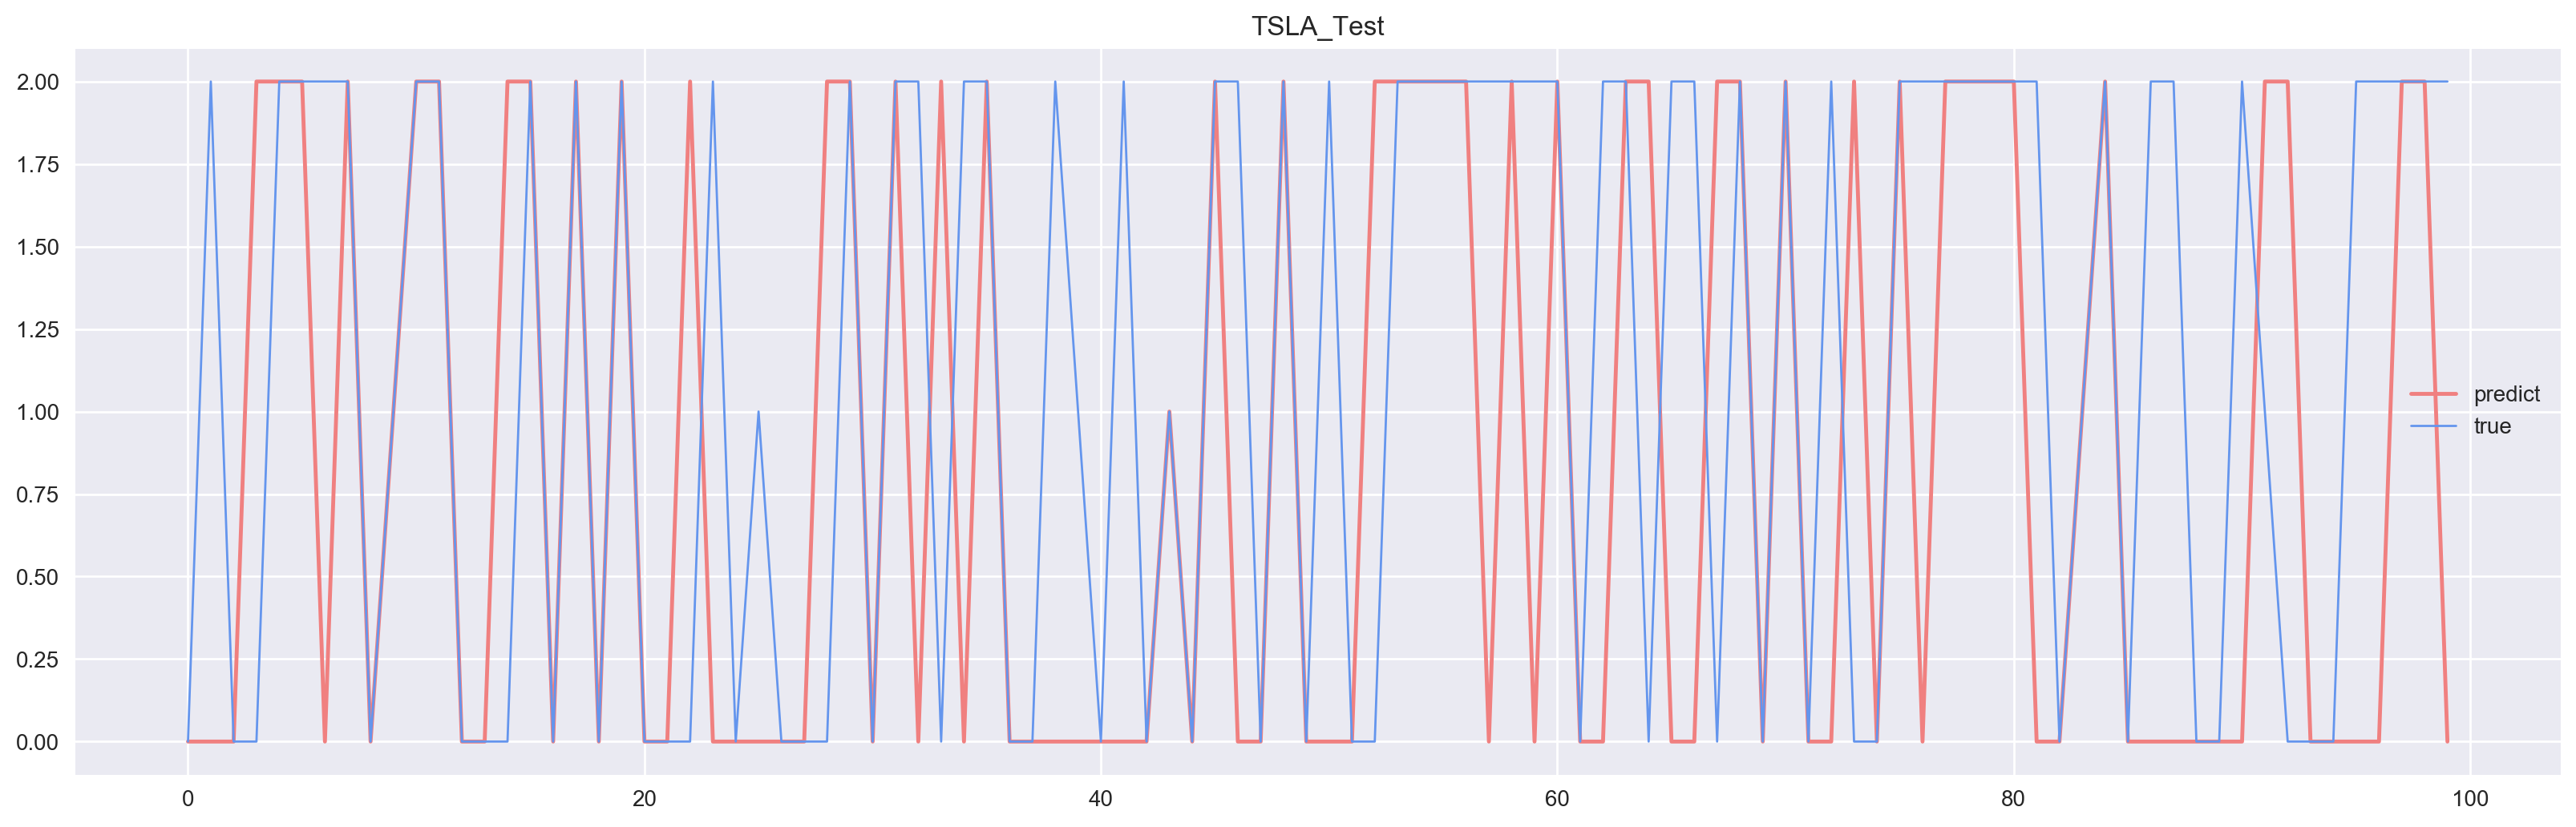

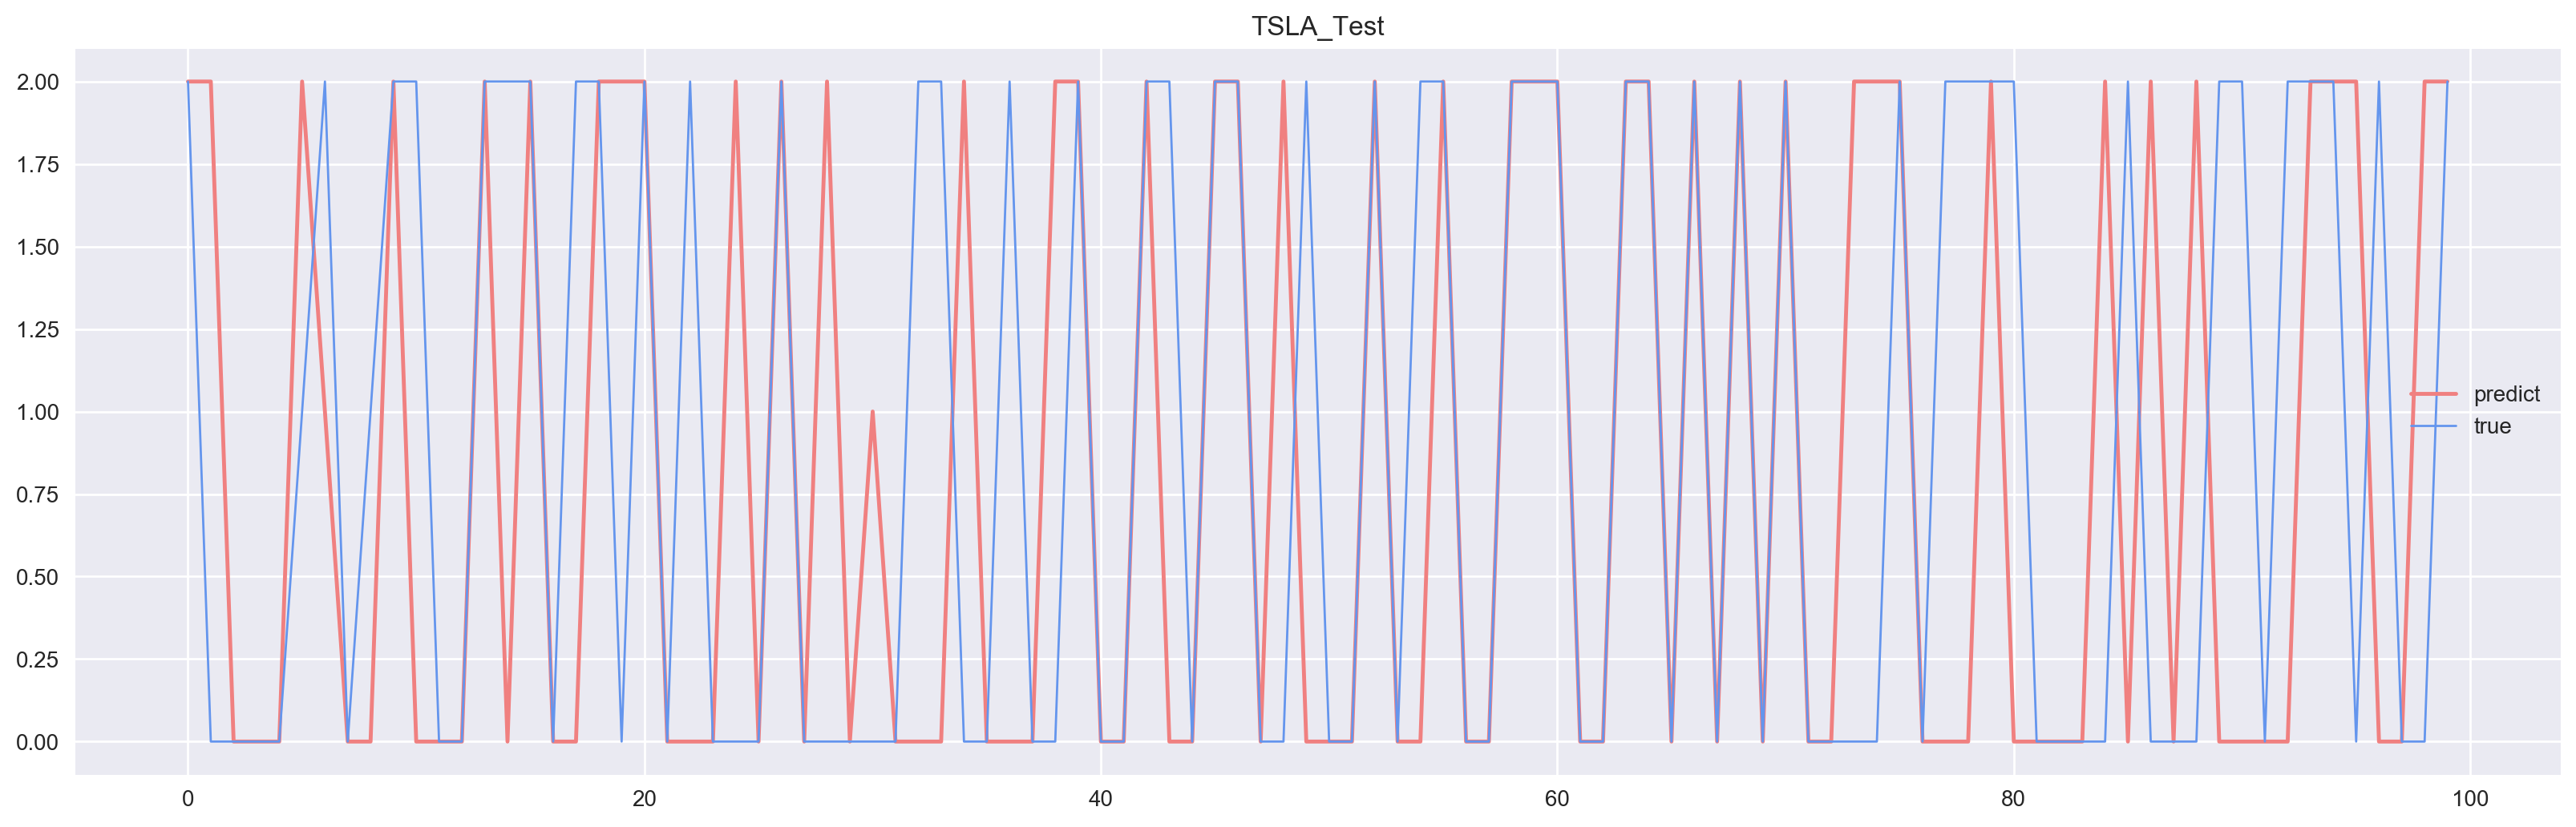

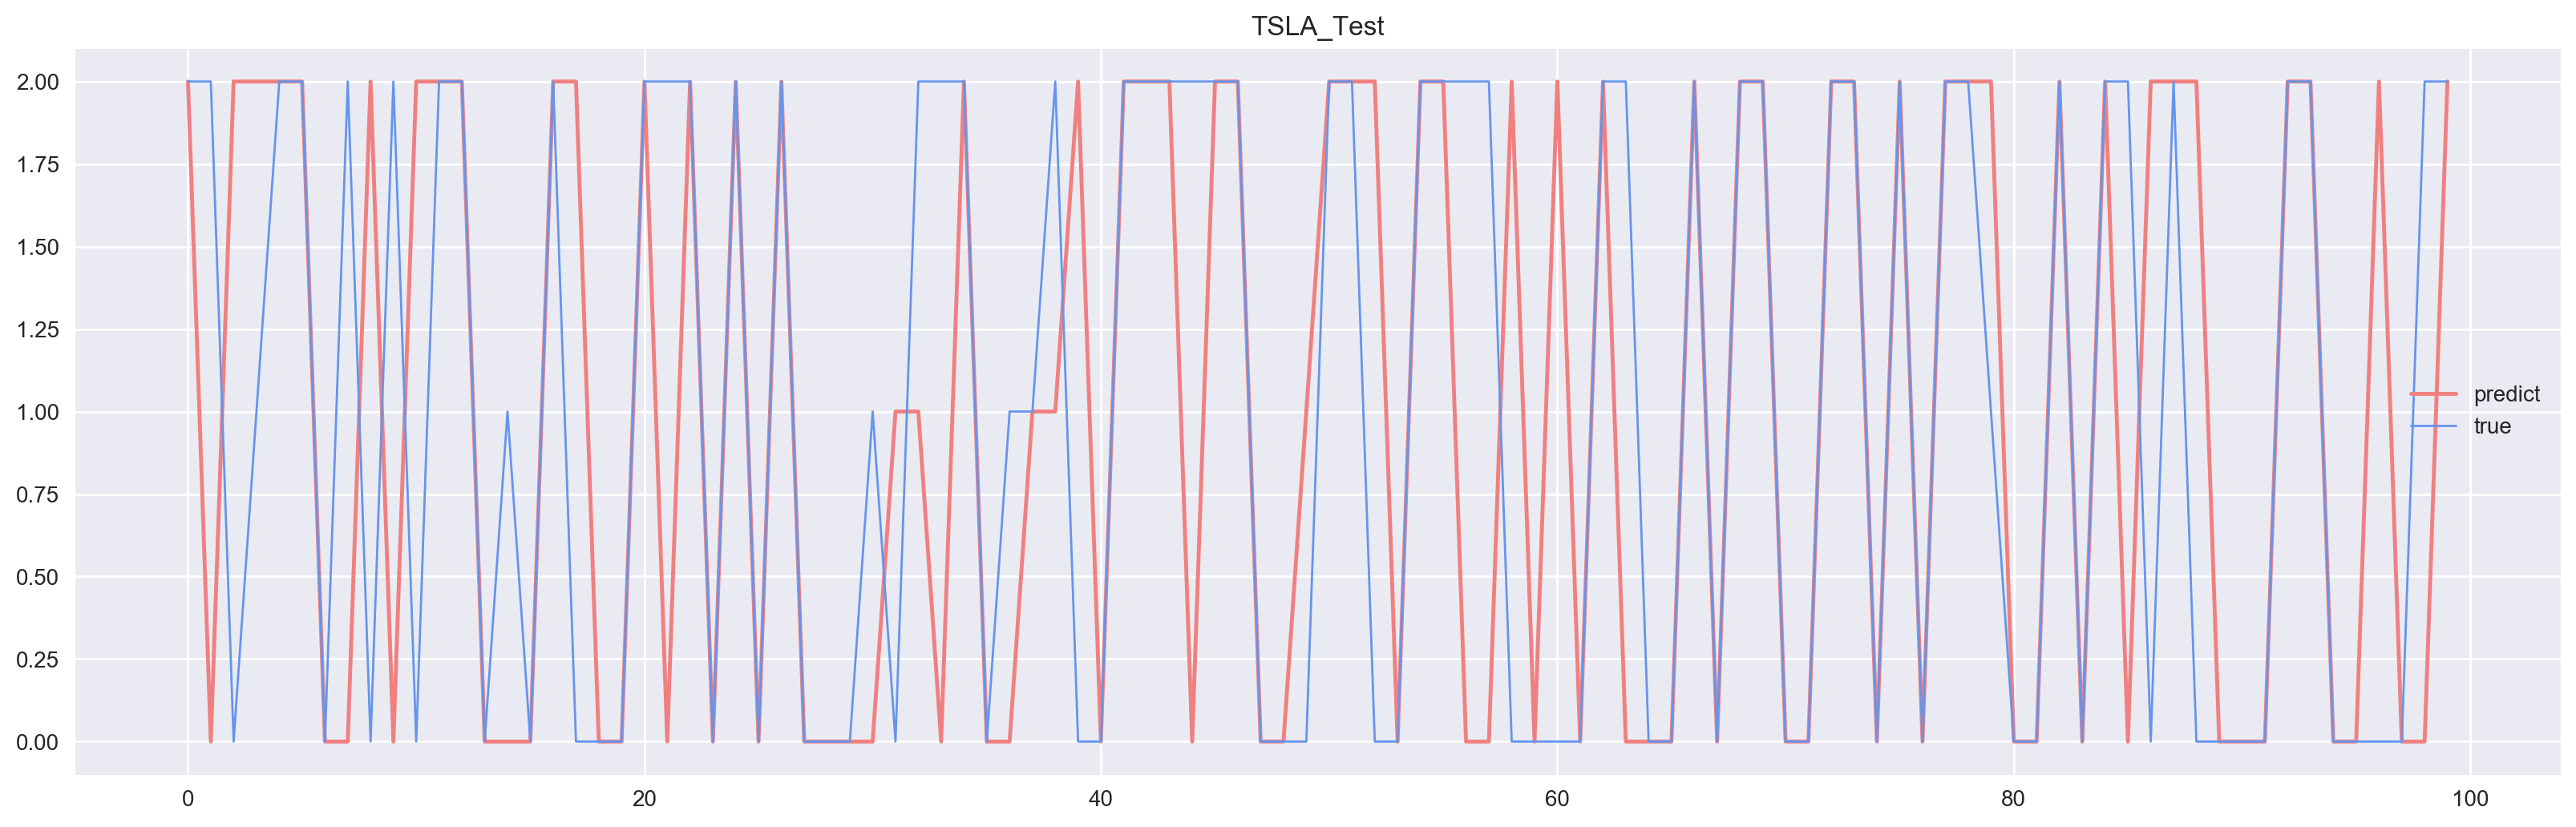

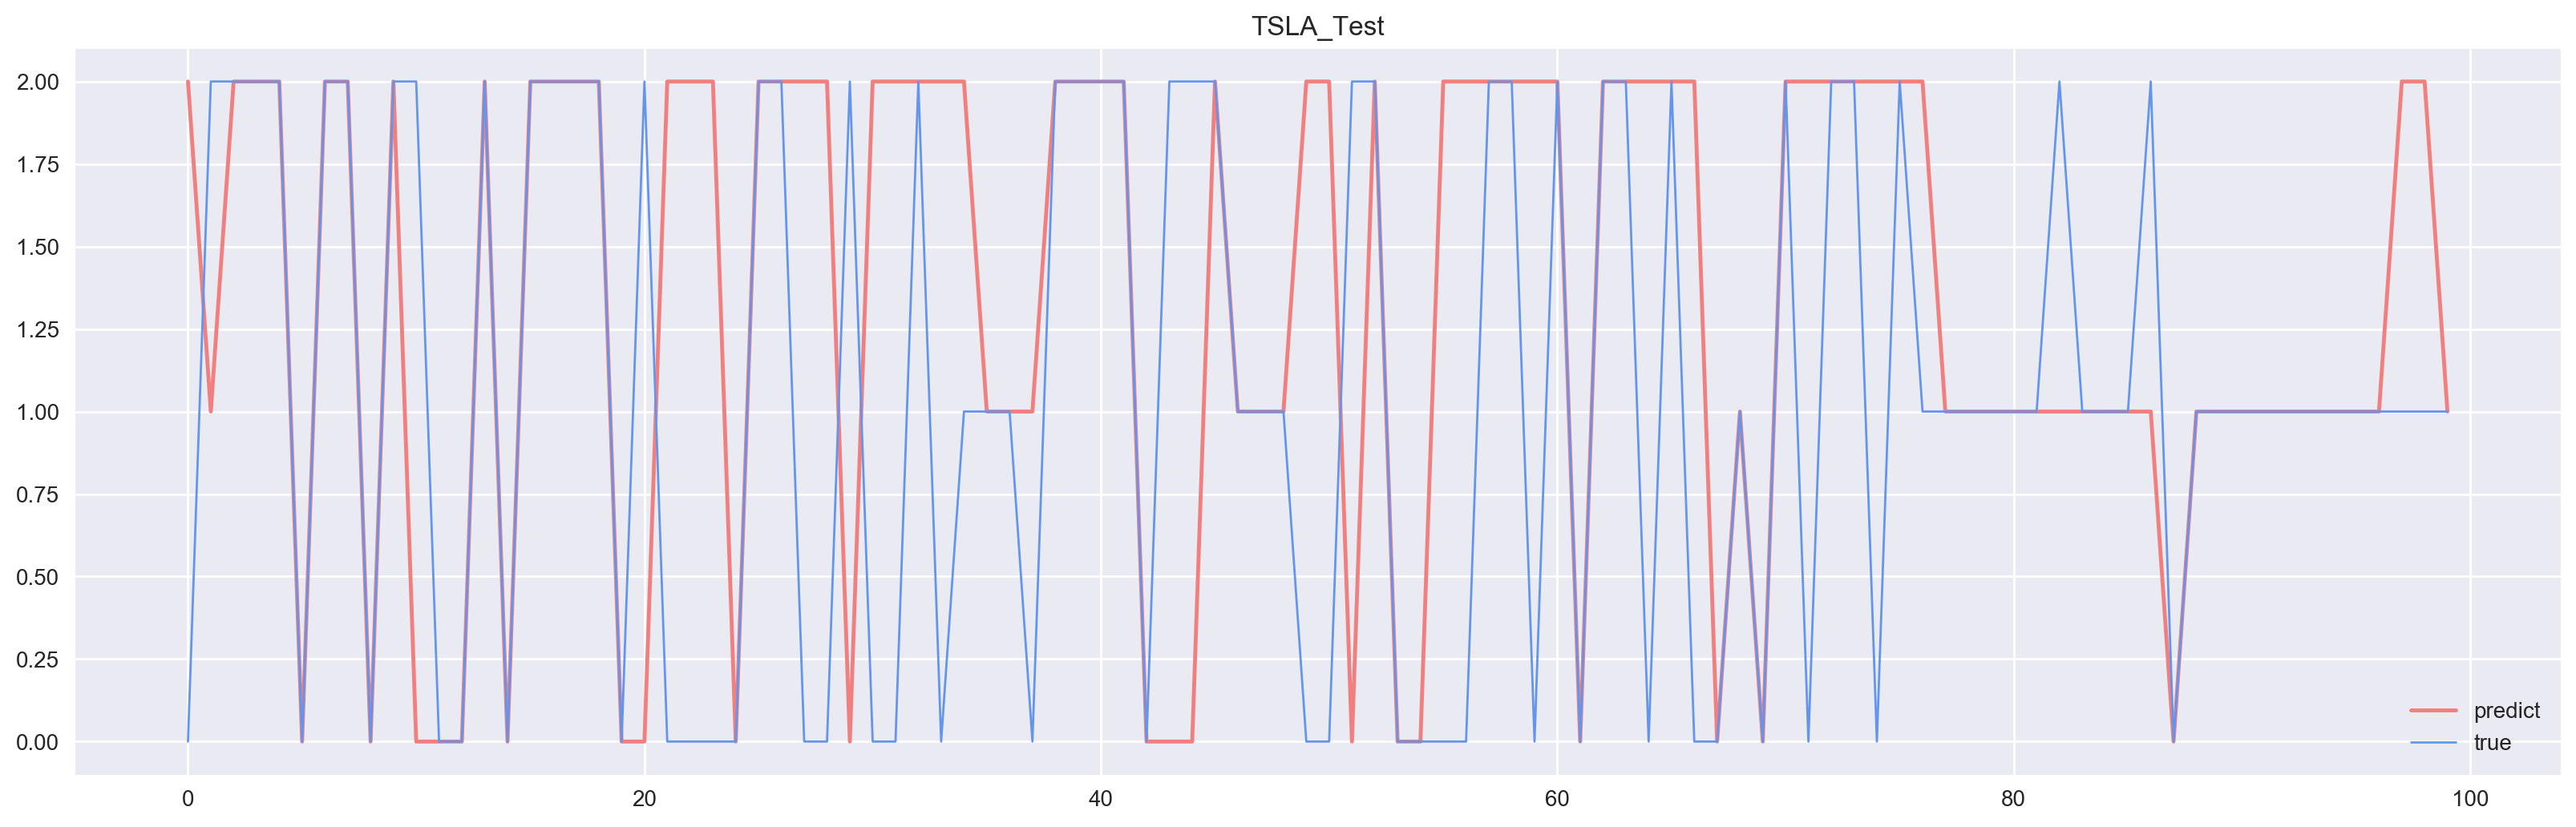

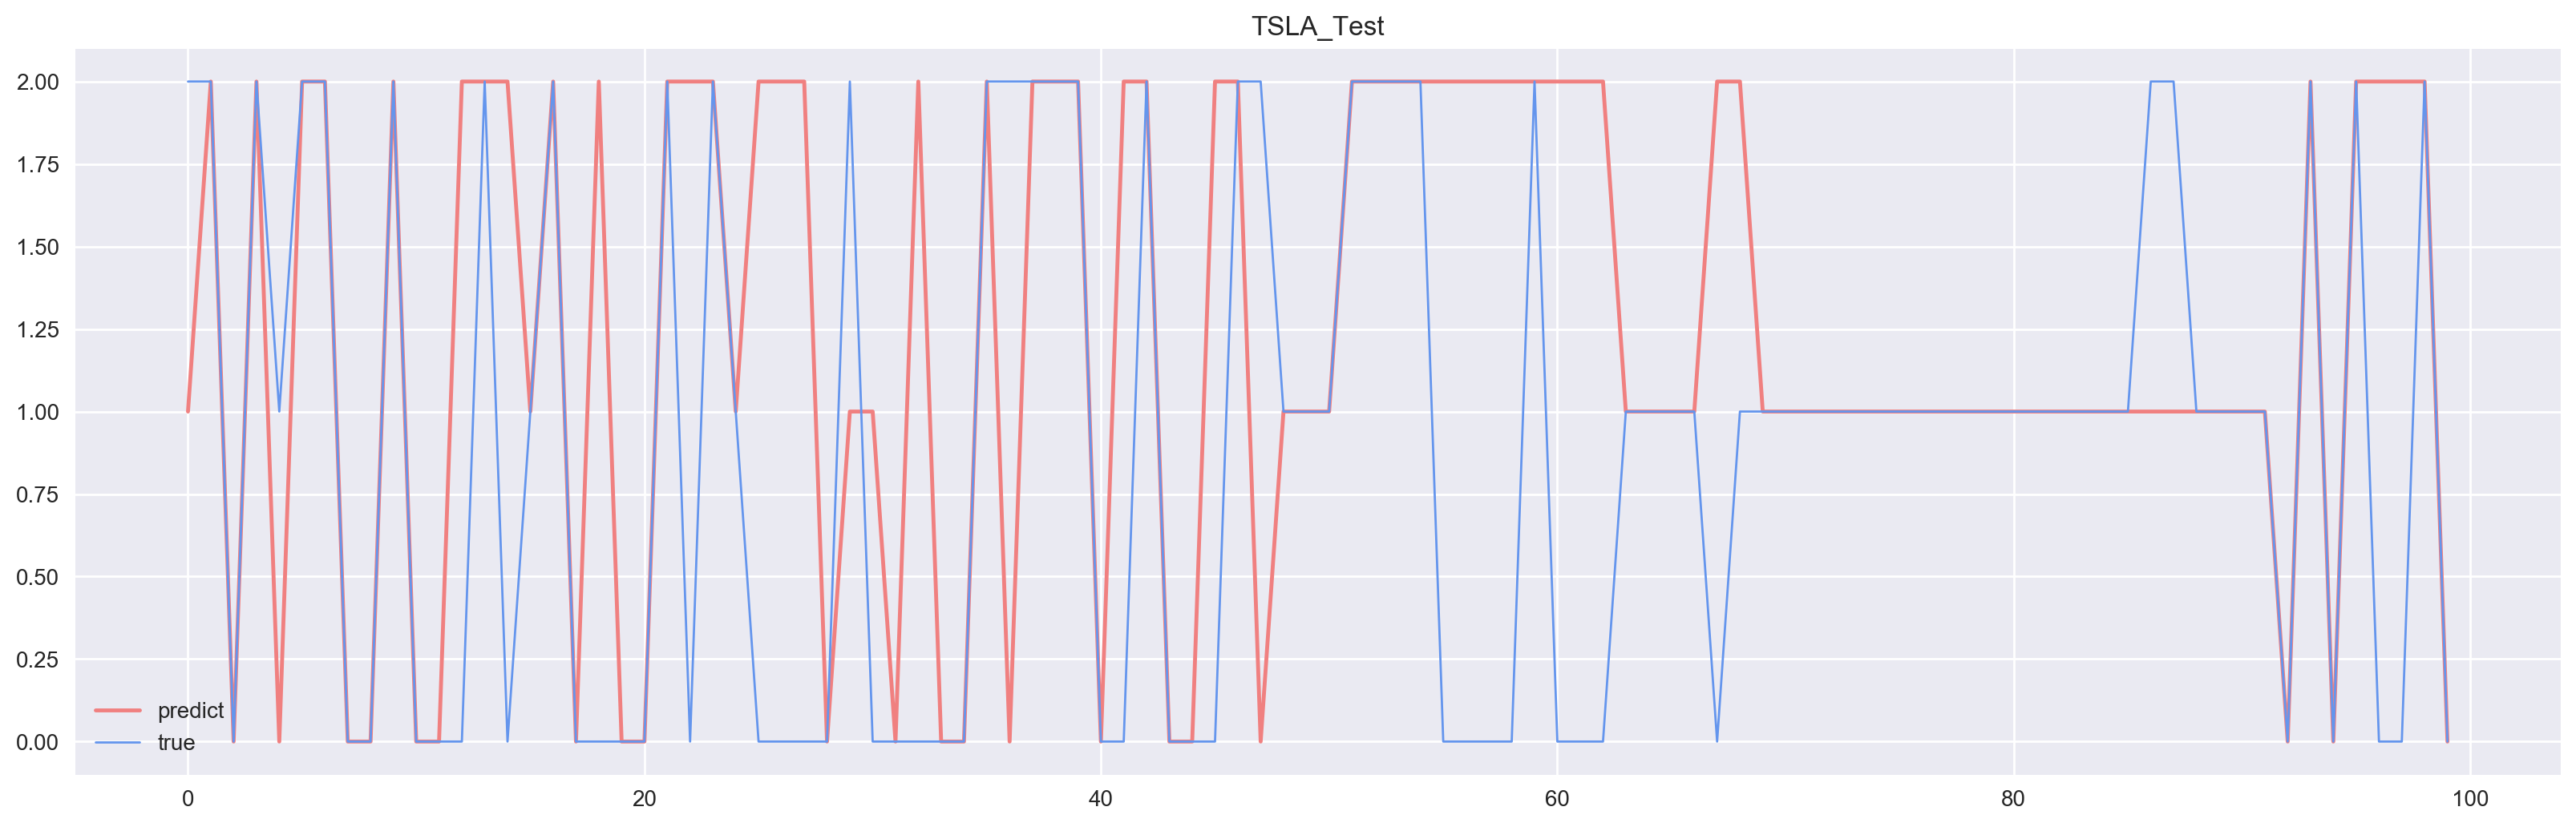

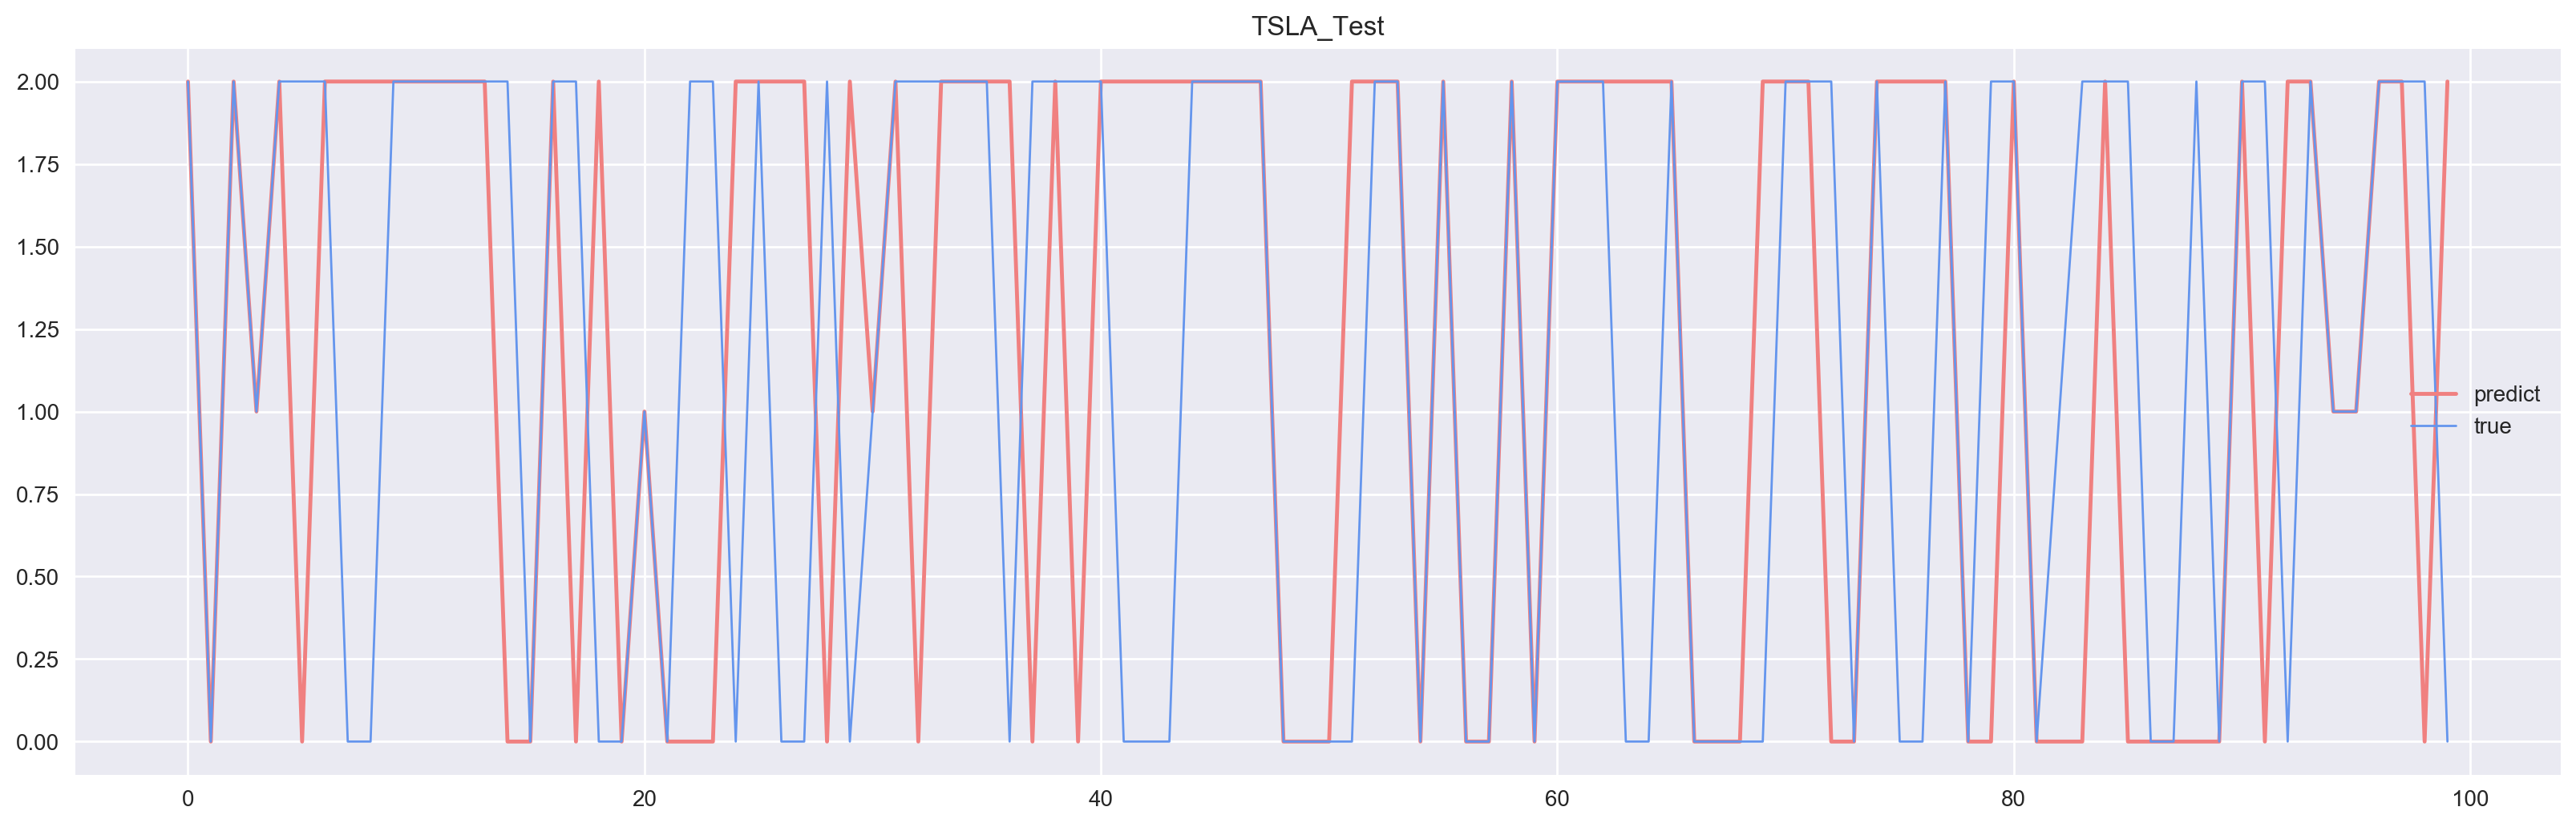

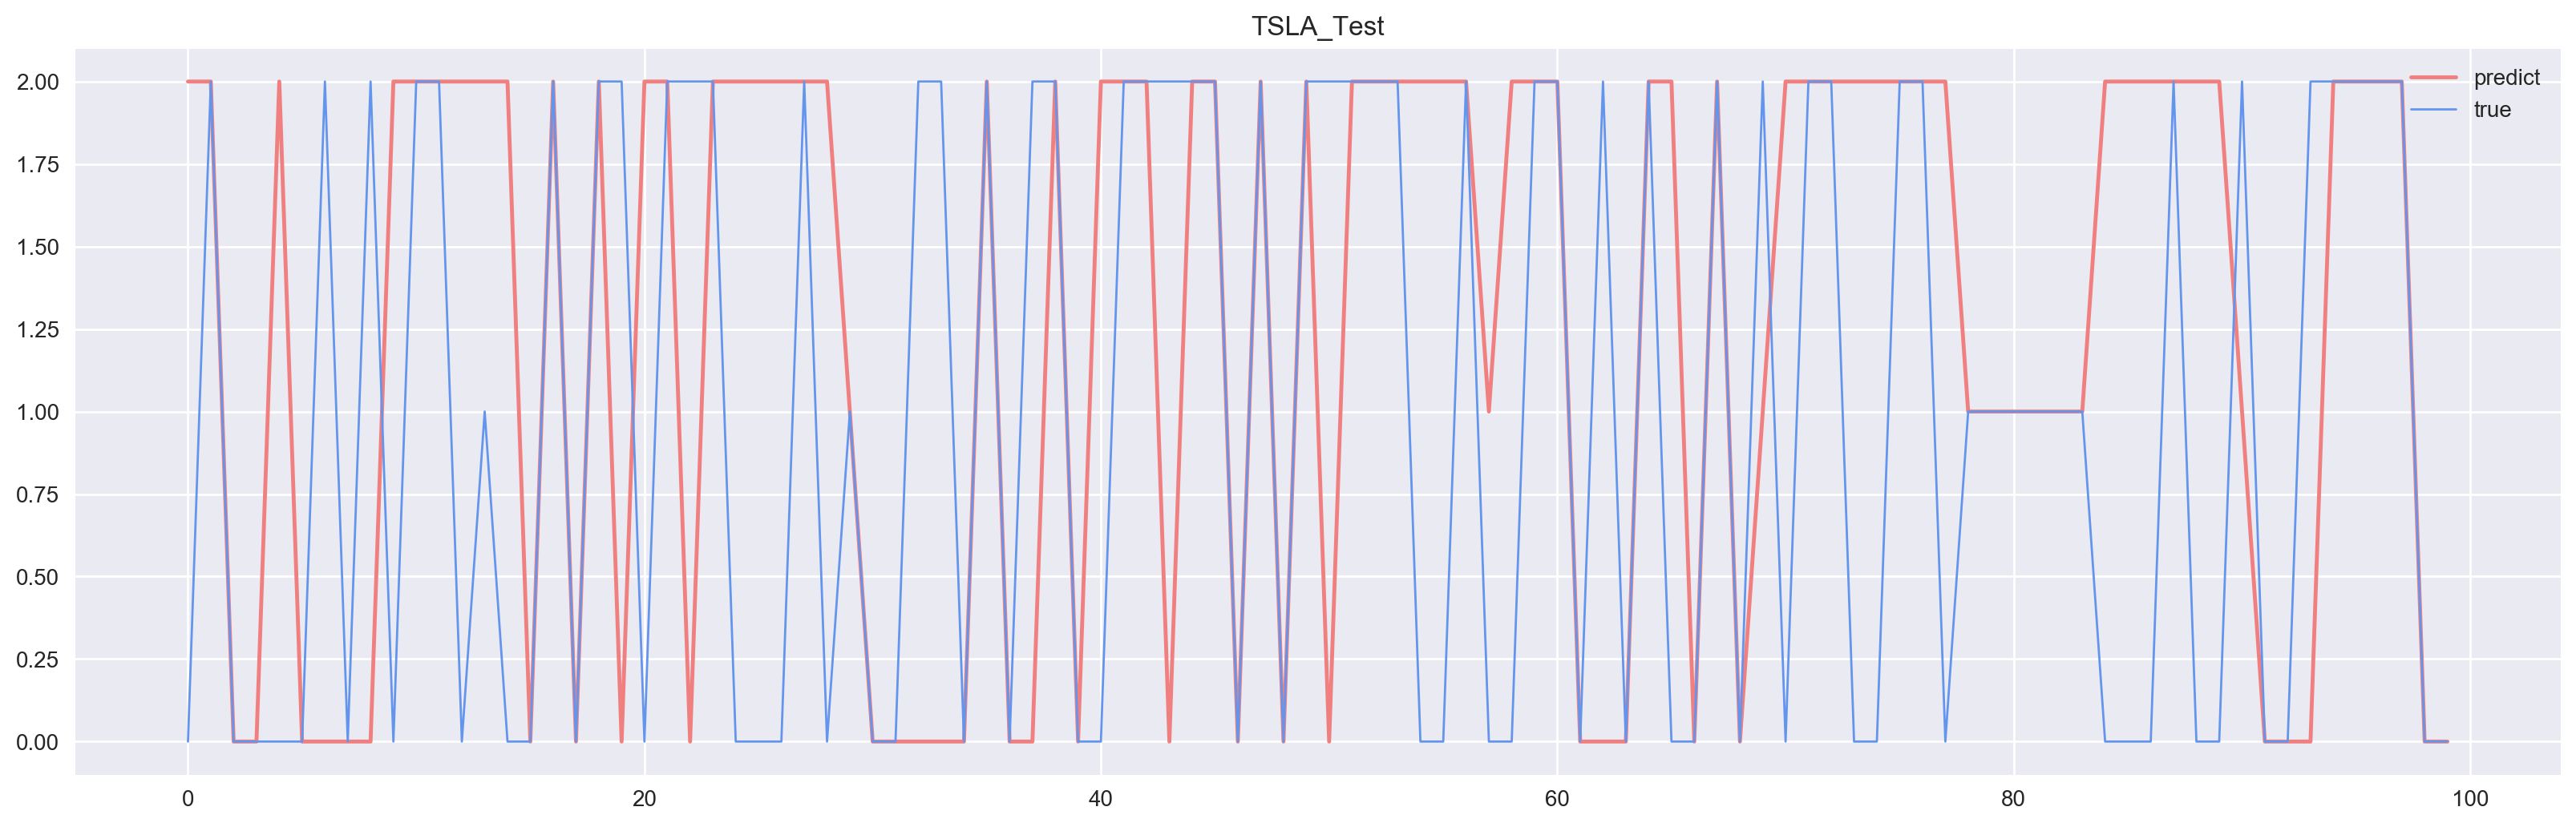

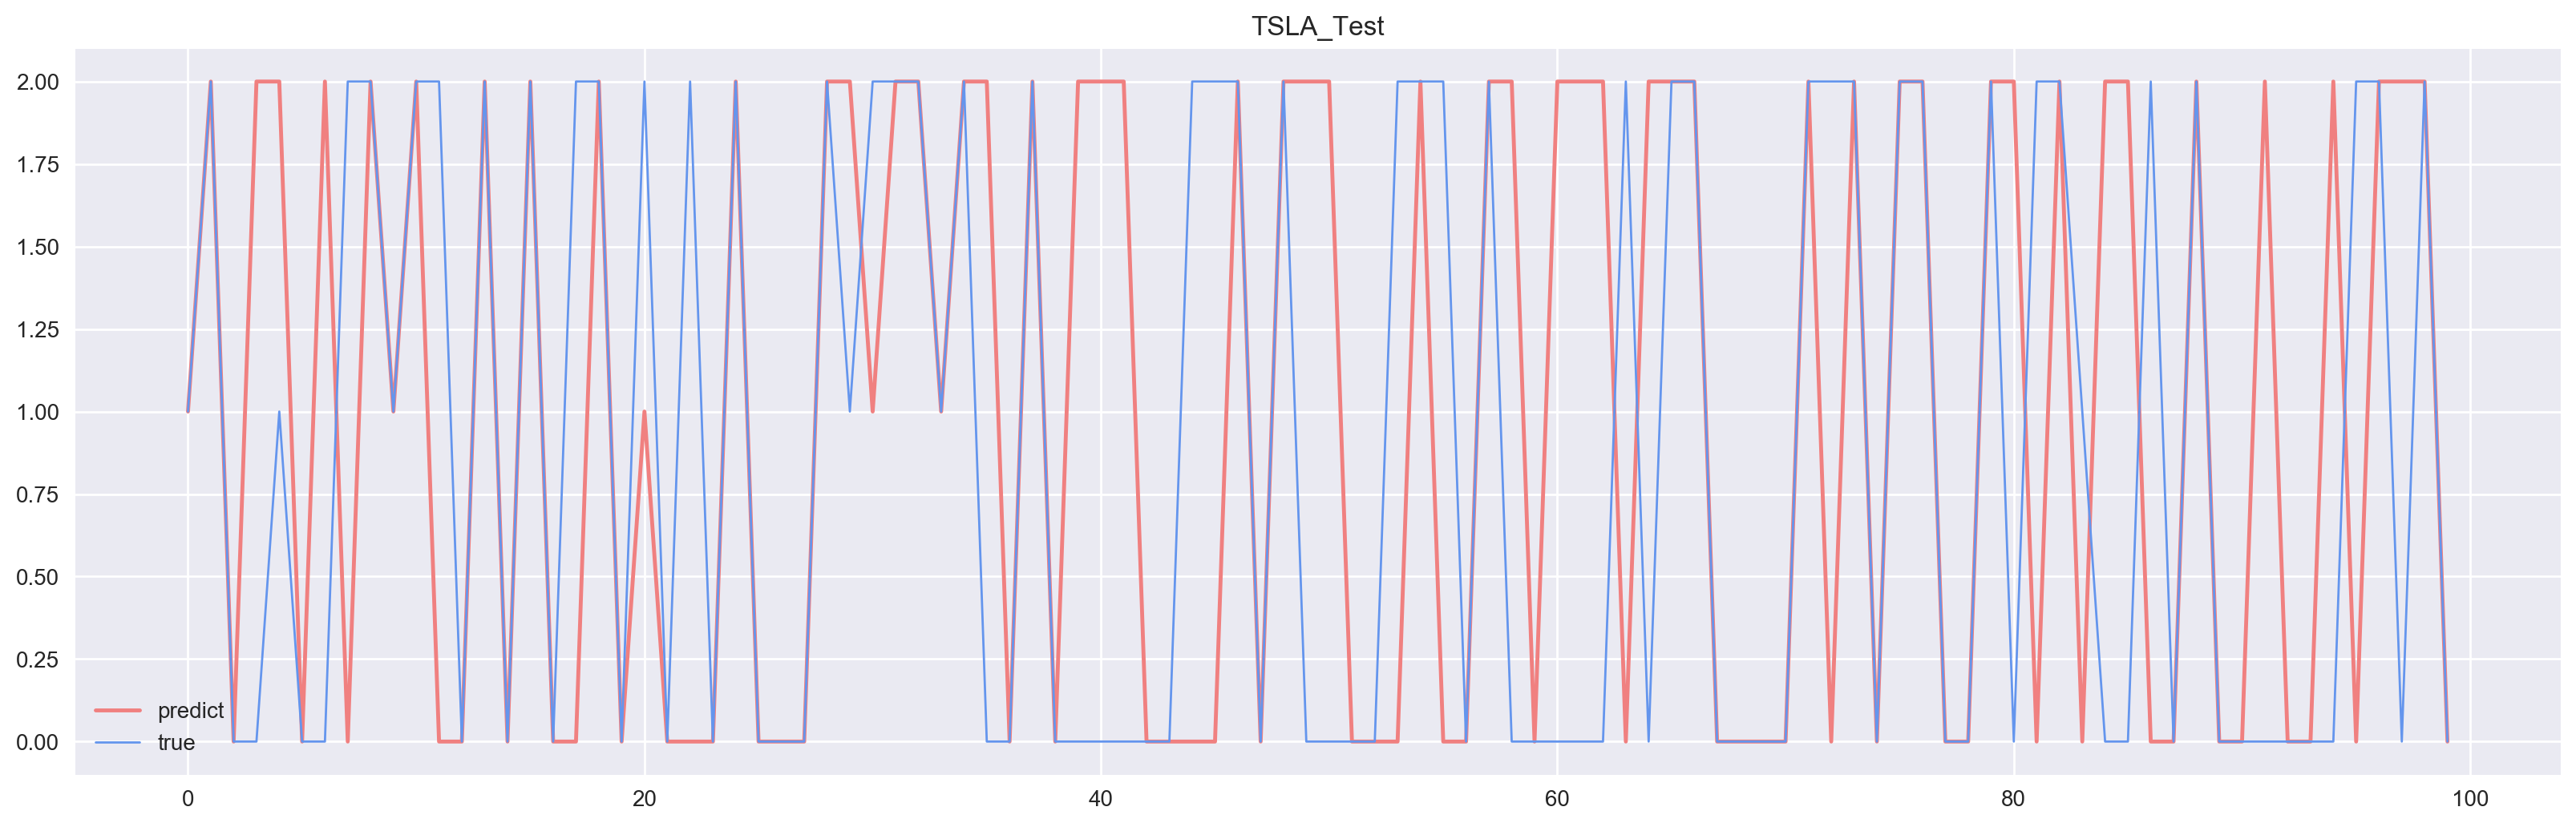

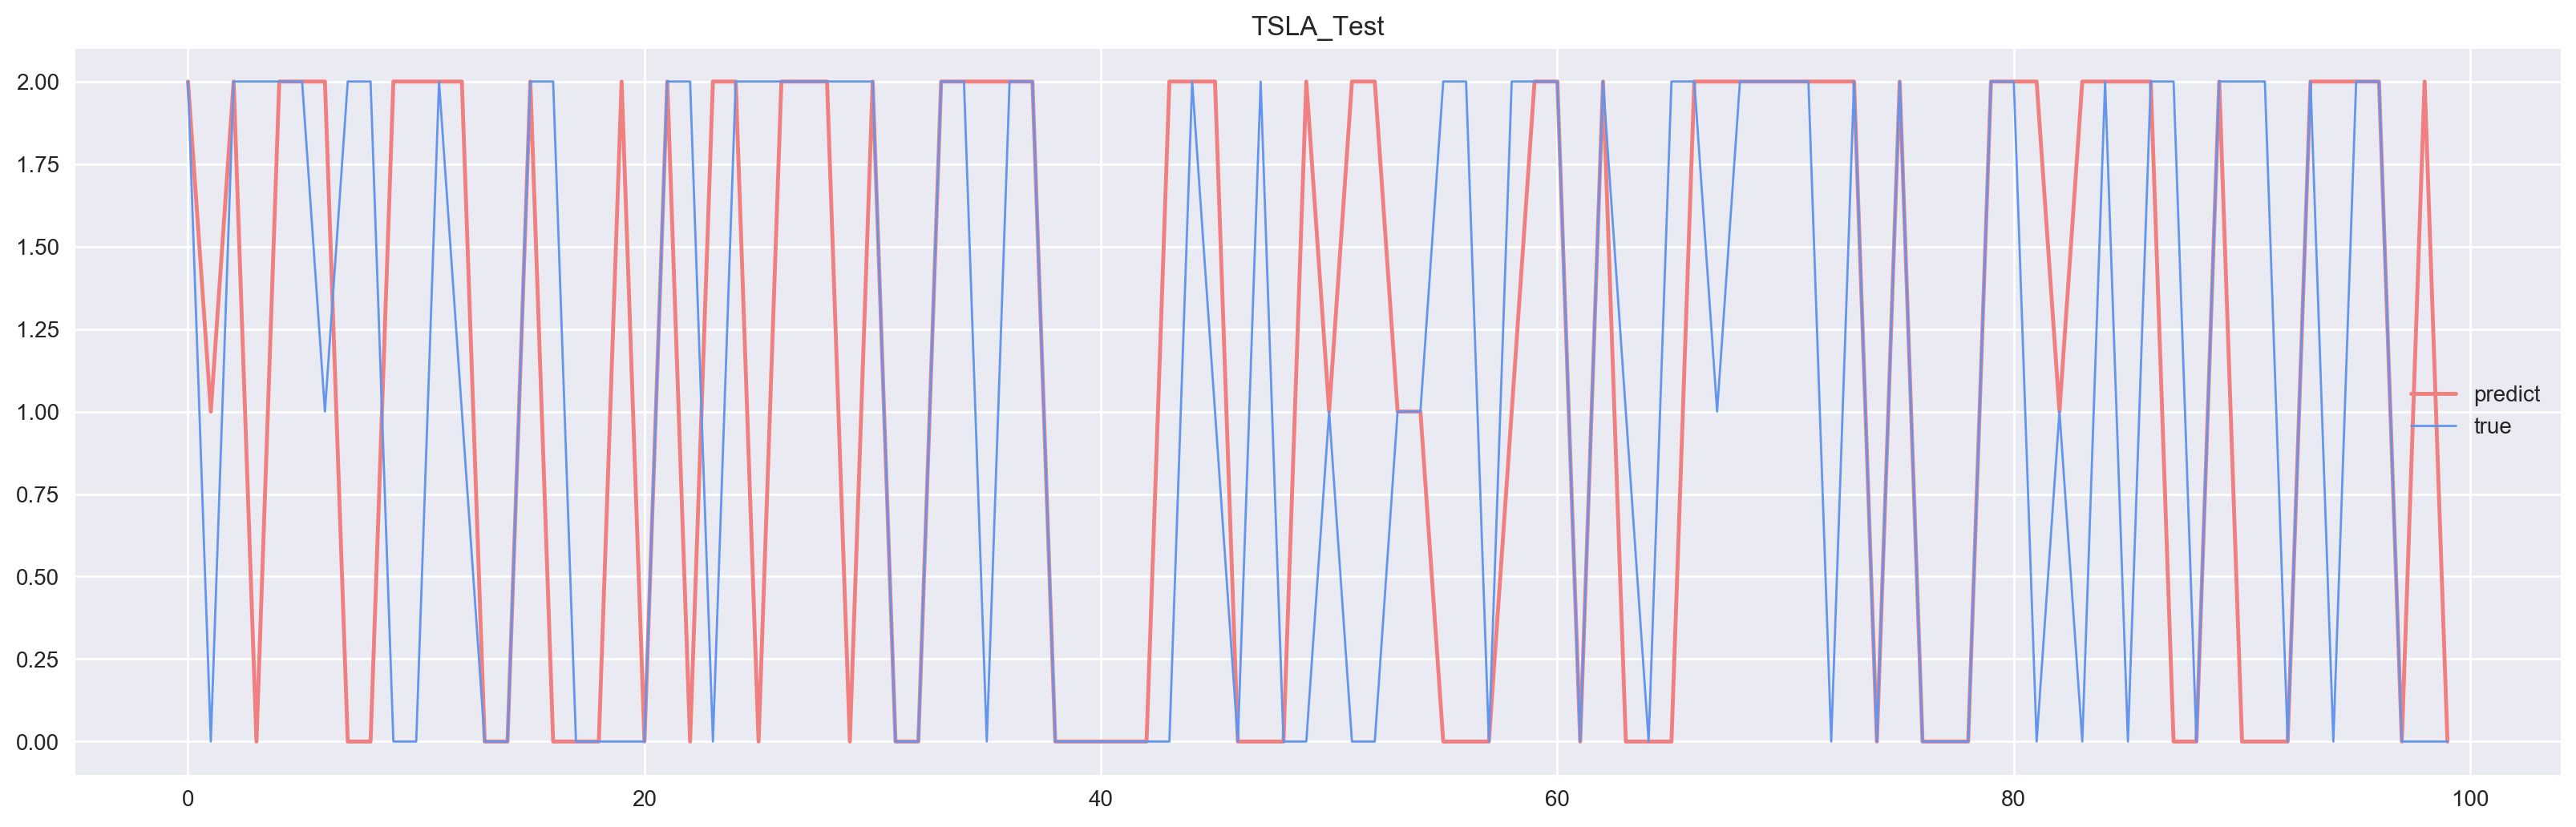

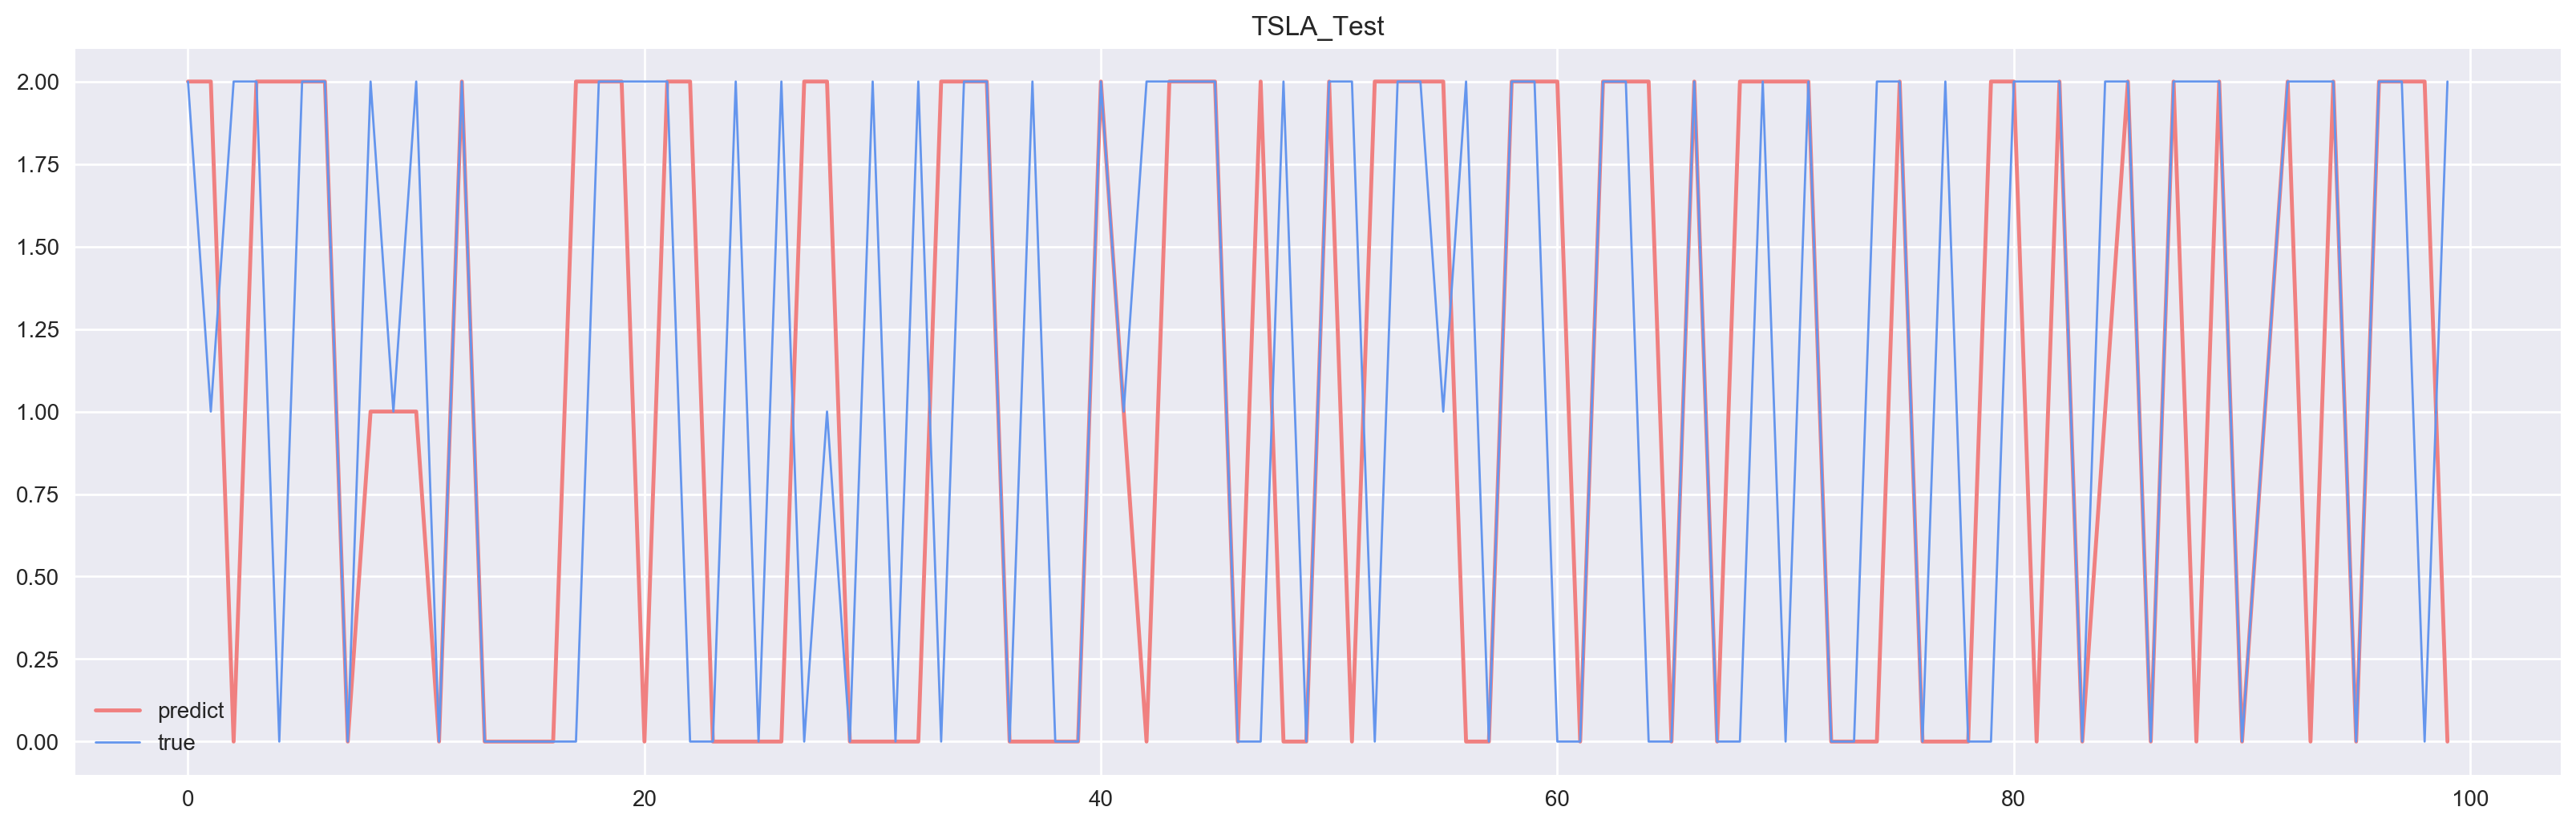

In [12]:
new_data_test(ticker)

In [57]:
# TICK FACTOR
# only update if it's a trade
# if message_type == 't':
#     # calc the tick
#     this_tick = np.sign(last_price - prev_price)
#     if this_tick == 0:
#         this_tick = prev_tick

#     # now calc the tick
#     if tick_factor == 0:
#         tick_factor = this_tick
#     else:
#         tick_factor = (tick_ema_alpha * this_tick) + (1 - tick_ema_alpha) * tick_factor

#         # store the last tick
#     prev_tick = this_tick

for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    
    df["tick_test"]=(df["trade_px"]-df["trade_px"].shift(1)).apply(lambda x: 1 if x>0. else (-1. if x<0 else np.nan))
    df.fillna(method="ffill",inplace=True)
    
    df["tick_factor"]=df["tick_test"].ewm(span=20).mean()
    df.dropna(axis=0,inplace=True)
    
    mysign = lambda x: 0 if abs(x)<1e-5 else (1 if x>0 else -1)
    df["predict"]=df["tick_factor"].apply(mysign)
    df["real_movement"]=(df["trade_px"].rolling(nforward).mean().shift(-nforward)-df["trade_px"]).apply(mysign)
    
    df.dropna(axis=0,inplace=True)
    acc=np.mean(df["predict"]==df["real_movement"])
    print("Accuracy of {}".format(test_date),acc)


Accuracy of 20190117 0.4707643580036127
Accuracy of 20190118 0.43095347731518396
Accuracy of 20190122 0.4555151005928208
Accuracy of 20190123 0.45868338302510847
Accuracy of 20190124 0.4674517203359969
Accuracy of 20190125 0.463677230280151
Accuracy of 20190128 0.48354217710885544
Accuracy of 20190129 0.45997873779839565
Accuracy of 20190130 0.45219857893910137
Accuracy of 20190131 0.4725264061508603


Average time interval is  0 days 00:00:02.477273


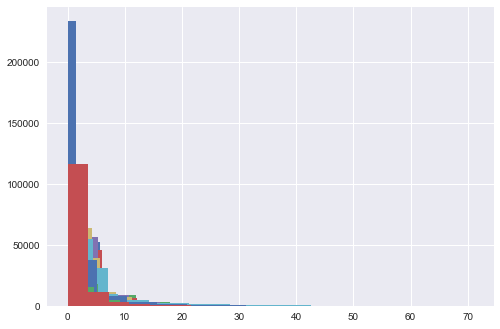

In [33]:
sum=pd.Timedelta(0)
count=0
for test_date in test_date_list:
    df = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(test_date, ticker),index_col=[0],parse_dates=[0])
    timestamp=pd.DataFrame({"trade_time":df.index})
    dt=timestamp["trade_time"].shift(-nforward)-timestamp["trade_time"]
    dt.dropna(axis=0,inplace=True)
    dt.apply(lambda x:x.seconds).hist()
    sum+=dt.sum()
    count+=dt.shape[0]
print("Average time interval between {} trades is".format(nforward),sum/count)